# RespInPeace: Toolkit for precessing breathing belt (RIP) data

In [1]:
import datetime
import matplotlib.pyplot as plt
import peakutils

# Silence FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## Data loading

Load data from a WAV file and plot the respiratory signal:

In [2]:
from rip import RIP

resp = RIP.from_wav('../data/resp.wav')

print('''Sampling frequency: {}
Number of samples: {}
Duration: {}'''.format(resp.samp_freq, len(resp.resp), datetime.timedelta(seconds=resp.dur)))

Sampling frequency: 200
Number of samples: 197368
Duration: 0:16:26.840000


In addition, reading the respiratory data from a CSV file listing is also supported using the `from_csv` constructor. See the documentation for how to use it.

While **RespInPeace** provides ways to automatically identify inhalations and exhalations in the respiratory signal, it is also possible to use one's own respiratory segmentation by specifying the `cycles` argument. See the documentation for details.

## Iteration, indexing and slicing

Time stamp and respiratory values are stored in `t` and `resp` attributes, respectively:

In [3]:
resp.t[:5], resp.resp[:5]

(array([0.   , 0.005, 0.01 , 0.015, 0.02 ]),
 array([ -662, -1360, -1200, -1292, -1227], dtype=int16))

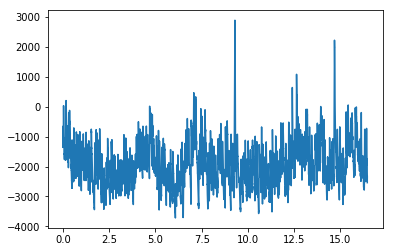

In [4]:
plt.plot(resp.t / 60, resp.resp)

RIP objects can be indexed and sliced both by sample and time indices:

In [5]:
resp[10:20:2]

array([-1204, -1180, -1158, -1140, -1127], dtype=int16)

In [6]:
resp.idt[0.05:0.1:0.01]

array([-1222, -1204, -1196, -1180, -1169, -1158, -1144, -1140, -1129,
       -1127], dtype=int16)

They can also be used as iterators:

In [7]:
for i, samp in enumerate(resp):
    if i > 10:
        break
    print(i, samp)

0 -662
1 -1360
2 -1200
3 -1292
4 -1227
5 -1261
6 -1223
7 -1241
8 -1219
9 -1222
10 -1204


# Detrending and drift removal

**RespInPeace** implements several detrending methods:
- Subracting the mean with `detrend(type='constant')`
- Removal of linear trend with `detrend(type='linear')`
- Removal with low-frequency baseline oscilation using a square window or a Savitzky-Golay filter.

Below we demonstrate the last of these methods:

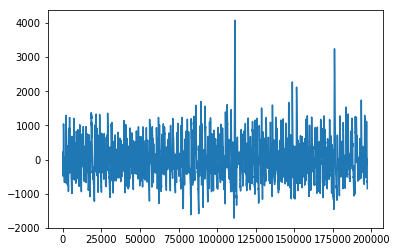

In [9]:
resp.remove_baseline_savgol(win_len=60)
plt.plot(resp.resp)

## Signal segmentation

### Detection of inhalations and exhalations

Inhalations and exhalations can be identified using the `find_cycles` method:

In [9]:
resp.find_cycles(include_holds=False)

In [10]:
type(resp.segments)

tgt.core.IntervalTier

In [11]:
resp.segments[:10]

[Interval(8.615, 10.24, "in"),
 Interval(10.24, 14.265, "out"),
 Interval(14.265, 14.87, "in"),
 Interval(14.87, 17.825, "out"),
 Interval(17.825, 18.82, "in"),
 Interval(18.82, 21.035, "out"),
 Interval(21.035, 21.555, "in"),
 Interval(21.555, 28.94, "out"),
 Interval(28.94, 29.65, "in"),
 Interval(29.65, 34.515, "out")]

It is also possible to access inhalations and exhalations, separately:

In [12]:
resp.inhalations[:5]

[Interval(8.615, 10.24, "in"),
 Interval(14.265, 14.87, "in"),
 Interval(17.825, 18.82, "in"),
 Interval(21.035, 21.555, "in"),
 Interval(28.94, 29.65, "in")]

In [13]:
resp.exhalations[:5]

[Interval(10.24, 14.265, "out"),
 Interval(14.87, 17.825, "out"),
 Interval(18.82, 21.035, "out"),
 Interval(21.555, 28.94, "out"),
 Interval(29.65, 34.515, "out")]

Finally, we can extract peak and trough times, stored in numpy arrays:

In [14]:
resp.peaks[:5]

array([10.24 , 14.87 , 18.82 , 21.555, 29.65 ])

In [15]:
resp.troughs[:5]

array([ 8.615, 14.265, 17.825, 21.035, 28.94 ])

Here is a plot showing the first couple of cycles.

(0, 50.0)

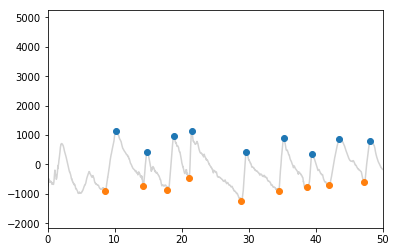

In [16]:
plt.plot(resp.t, resp.resp, color='lightgrey')
plt.plot(resp.peaks, resp.idt[resp.peaks],
         linestyle='none', marker='o')
plt.plot(resp.troughs, resp.idt[resp.troughs],
         linestyle='none', marker='o')
plt.xlim(0,  1e4 /  resp.samp_freq)

Given this representations, calculating durational features is extremely easy. For instance, below  we calculate and plot the distribution of inhalation durations:

In [17]:
inh_durs = [i.duration() for i in resp.inhalations]

We can also visualise them:

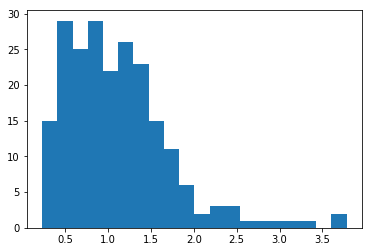

In [18]:
_ = plt.hist(inh_durs, bins=20)

### Hold detection

Hold detection follows an adapted version of the method implemented in [Breathmetrics](https://github.com/zelanolab/breathmetrics): For each respiratory segment (inhalation and exhalation) we construct a histogram of respiratory values. Since respiratory holds result is speakers staying at the same lung volume for a while, they are identified as peaks in the histogram.

The specifics of hold detection can be controlled arguments passed to the `find_holds` method:
* `bins` (default: 100) - the number of bins used to construct the histogram.
* `peak_prominence` (default 0.05) - the minimal peak prominence (as returned by [`scipy.signal.peak_prominences`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html)) corresponding to a respiratory hold.
* `min_hold_gap` (default: 0.15) - neighbouring holds separated by a gap shorter than this value will be merged.
* `min_hold_dur` (default: 0.25 s) - holds shorter than this value will be omitted. Note that this criterion is applied after merging of neighbouring holds using the value of `min_hold_gap` above.

In [19]:
resp.find_holds()
resp.holds[:10]

[Interval(17.025, 17.54, "hold"),
 Interval(36.625, 36.925, "hold"),
 Interval(37.34, 37.73, "hold"),
 Interval(40.335, 40.59, "hold"),
 Interval(45.2, 45.765, "hold"),
 Interval(72.99, 73.715, "hold"),
 Interval(86.64, 87.14, "hold"),
 Interval(89.7, 90.035, "hold"),
 Interval(130.01, 131.02, "hold"),
 Interval(141.595, 142.15, "hold")]

Below, we plot the first four holds for illustrative purposes:

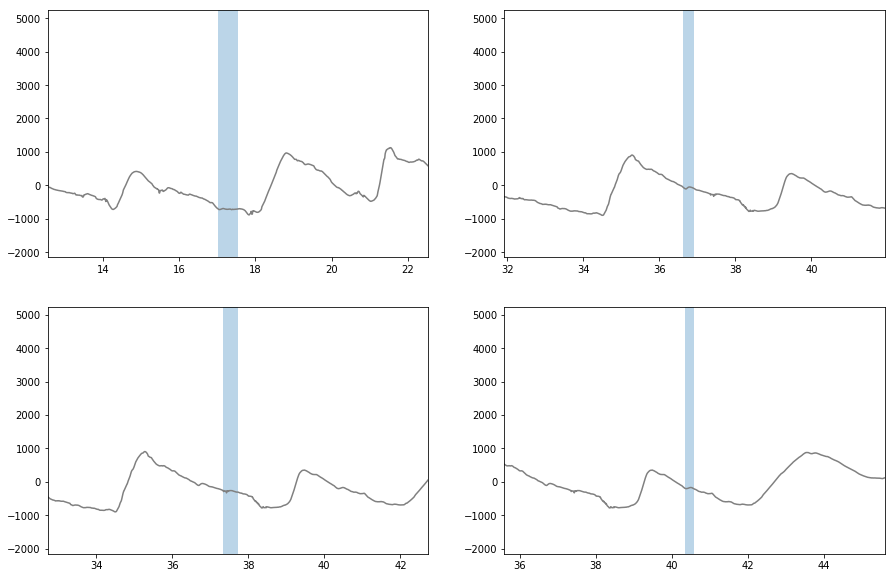

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

mar = 5
for i, ax in enumerate(axs.flatten()):
    hold = resp.holds[i]
    ax.plot(resp.t, resp.resp, color='grey')
    ax.axvspan(hold.start_time, hold.end_time, alpha=0.3)
    ax.set_xlim(hold.end_time - mar, hold.end_time + mar)

## Range estimation

Respiratory range is estimated in terms of the bottom and top percentiles of peak and trough respiratory values. By default, the 5th and 95 percentiles are used. In other words, the bottom- and top-most 5 per cent of peaks and troughs are discarded.

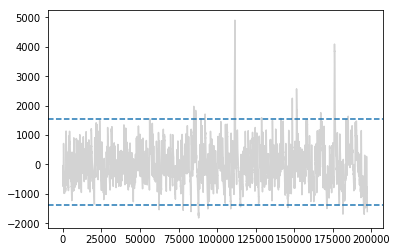

In [21]:
resp.estimate_range()

plt.plot(resp.resp, color='lightgrey')
plt.axhline(resp.range_bot, linestyle='dashed')
plt.axhline(resp.range_top, linestyle='dashed')

## REL estimation

Resting expiratory level(REL) is the state of equilibrium when the expiratory elasticity forces equal the the inhalatory elasticity forces. It also the point within the total lung capacity where speakers are most likely to inhale as speaking at lung volumes below REL is generally felt to be quite uncomfortable.

RespInPeace offers two ways of estimating REL. By default, it will use a *static* REL value calculated as the median of all respiratory troughs.

In [22]:
resp.estimate_rel(dynamic=False)

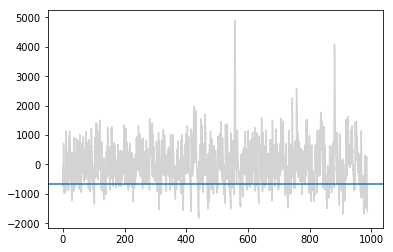

In [23]:
plt.plot(resp.t, resp.resp, color='lightgrey')
plt.axhline(resp.rel)

(30, 120)

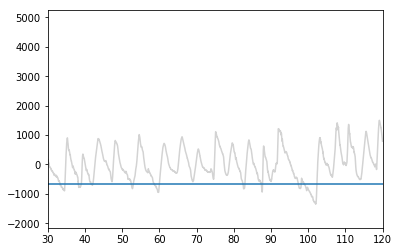

In [24]:
plt.plot(resp.t, resp.resp, color='lightgrey')
plt.axhline(resp.rel)
plt.xlim(30, 120)

REL is quite sensitive to posture shifts and if the subject did not stand perfectly still, might fluctuate in the course of a recording. In order to neutralize the effect this drift, REL needs to be estimated in a more dynamic way. RestInPeace estimates REL by as the median signal level at respiratory troughs in the preceding interval of specified duration (??? by default).

In [40]:
resp.estimate_rel(dynamic=True, lookbehind=30)

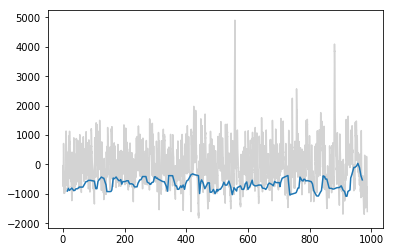

In [41]:
plt.plot(resp.t, resp.resp, color='lightgrey')
plt.plot([i.start_time for i in resp.inhalations], resp.rel)

(30, 120)

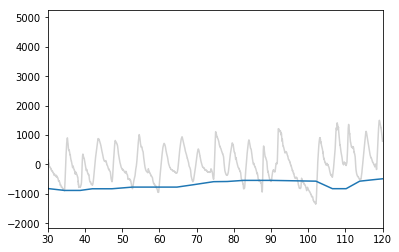

In [37]:
plt.plot(resp.t, resp.resp, color='lightgrey')
plt.plot([i.start_time for i in resp.inhalations], resp.rel)
plt.xlim(30, 120)

## Writing to files

### Respiratory data

The respiratory signal can be save to a file with the `save_resp` method. By default, the data is saved to a WAV file.

In [29]:
resp.save_resp('resp_saved.wav')

Alternatively, the data can be saved to a CSV file by passing a `filetype="table"` argument to `save_resp`. See the documentation for more details.

### Annotations

The annotations (inhalation, exhalation and hold boundaries) can be saved to a file with the `save_annotations` method. By default, they are saved to a [PRAAT](http://www.fon.hum.uva.nl/praat/) TextGrid files (the so-called short format). Other supported formats are `"eaf"` (for [ELAN](https://tla.mpi.nl/tools/tla-tools/elan/) EAF XML-based format) and `"table"` for a CSV (comma-separated) file. The tiers to save can be specified using the `tiers` argument to `save_annotations`.

In [30]:
resp.save_annotations('resp.TextGrid', tiers=['cycles', 'holds'])

If `merge_holds` is True, the holds are merged with the respiratory segmentation. In that case, the holds tier is not included in the output.